# Creating spectrograms

In [1]:
import torch
from torch.utils import data
from torchaudio import datasets
import numpy as np
import os, pathlib
from scipy.io import wavfile
from scipy import signal
from tqdm import tqdm

from torchaudio import transforms as tf_audio
from torchvision import transforms as tf_img
from torchvision.transforms import functional as fn
import torch.nn.functional as fn_t
import torch.nn as nn

import einops
import matplotlib.pyplot as plt
import librosa
import noisereduce as nr
import copy


/home/mpuscian/Envs/DeepLearning/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trainPath = "/home/mpuscian/Desktop/repozytoria/MINI_projects/Transformers/data/processed/splited_data/train/"

In [3]:
valPath = "/home/mpuscian/Desktop/repozytoria/MINI_projects/Transformers/data/processed/splited_data/validation/"

In [32]:
class TensorflowDataset:
    """
    Import paths of files
    """
    def __init__(self, directory : str, transforms, DEBUG : bool = False):
        self.directory = str
        self.paths = []
        self.labels = []
        self.background_noise_label = "_background_noise_"
        self.transforms = transforms

        for i, (root, dirs, files) in enumerate(os.walk(directory)):

            if files:
                label = pathlib.Path(root).parts[-1]
                if label != self.background_noise_label:
                    for file in tqdm(files):
                        filepath = os.path.normpath(os.path.join(root, file))
                    
                        self.paths.append(filepath)
                        self.labels.append(label)

        if not DEBUG:
            assert len(np.unique(self.labels)) == 30

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file_sr, file_data = wavfile.read(self.paths[idx])
        
        if self.transforms:
            return self.transforms(file_data), self.labels[idx]
        else:
            return file_data, self.labels[idx]

In [5]:
class NoiseReducer:
    def __init__(self, sample_noise = None, sr=16000, **kwargs):
        self.sample_noise = sample_noise
        self.kwargs = kwargs
        self.sr = sr

    def __call__(self, data):
        if self.sample_noise:
            noise_sample = data[:int(self.sr * 0.5)]
        return nr.reduce_noise(y=data, y_noise = noise_sample if self.sample_noise else None, sr=self.sr, **self.kwargs)

class Resample:
    def __init__(self, sample_rate = 16000):
        self.sr = sample_rate
    def __call__(self, data):
        return librosa.resample(data.astype(float), orig_sr=len(data), target_sr = self.sr)

class ToFloatTensor:
    def __call__(self, data):
        return torch.from_numpy(data).float()

class HannWindow:
    def __call__(self, data):
        return signal.windows.hann(self.window_length)

In [6]:
class PatchEmbedding:
    """
    Takes as input image n by m.
    Outputs tensor (batch_qantity, num_of_patches, patch_x, patch_y)
    """

    def __init__(self, img_dim, patch_dim = (10,10)):
        self.img_dim = img_dim
        self.patch_dim = patch_dim

        assert img_dim[0] % patch_dim[0] == 0
        assert img_dim[1] % patch_dim[1] == 0
        
    def __call__(self, img):

        
        assert img.dim() == 3 or img.dim() == 2

        if img.dim() == 3:
            patches = einops.rearrange(
            img, 
            '(b) (h ph) (w pw) -> b (h w) ph pw', 
            ph=self.patch_dim[0], pw=self.patch_dim[1]
            )
        elif img.dim() == 2:
            patches = einops.rearrange(
            img, 
            '(h ph) (w pw) -> (h w) ph pw', 
            ph=self.patch_dim[0], pw=self.patch_dim[1]
            )
        return patches

In [33]:
SAMPLE_RATE = 16000
patch_dim=(16,15)
img_dim=(64, 105)

transforms = tf_img.Compose([
    NoiseReducer(sample_noise=True, sr=16000, stationary=True),
    Resample(sample_rate=16000),
    ToFloatTensor(),
    tf_audio.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=256, hop_length=153),
    PatchEmbedding(img_dim=img_dim, patch_dim=patch_dim)
])


trainset = TensorflowDataset(trainPath, transforms=transforms, DEBUG=True)
trainloader = data.DataLoader(trainset, batch_size=256, pin_memory=True, num_workers=6, shuffle=True)
valset = TensorflowDataset(valPath, transforms=transforms, DEBUG=True)
valloader = data.DataLoader(valset, batch_size=256, pin_memory=True, num_workers=6, shuffle=True)

/home/mpuscian/Envs/DeepLearning/lib64/python3.13/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 1680306.69it/s]


output_data_dir = "processed_data/train/data"
output_label_dir = "processed_data/train/labels"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)


PREPROC_BATCH_SIZE = 256

print(f"Starting pre-processing (batch_size={PREPROC_BATCH_SIZE}) and saving individual items...")
item_count = 0
for batch_data, batch_labels in trainloader:
    # Loop through each item WITHIN the loaded batch
    for i in range(batch_data.size(0)):
        data_item = batch_data[i]     # Get the i-th item from the batch
        label_item = batch_labels[i] # Get the i-th label from the batch

        # Define unique filenames for the individual item
        data_filename = os.path.join(output_data_dir, f"item_{item_count:08d}.pt")
        label_filename = os.path.join(output_label_dir, f"item_{item_count:08d}.pt")

        # Save the individual transformed tensors
        torch.save(data_item, data_filename)
        torch.save(label_item, label_filename)

        item_count += 1 # Increment counter for each individual item saved

        if item_count % 1000 == 0:
            print(f"Saved {item_count} items...")

print(f"Finished saving {item_count} items.")

In [8]:
# --- In your training script ---
from torch.utils.data import Dataset
import glob

class PreprocessedDataset(Dataset):
    def __init__(self, data_dir, label_dir, online_transforms=None):
        self.data_files = sorted(glob.glob(os.path.join(data_dir, "*.pt")))
        self.label_files = sorted(glob.glob(os.path.join(label_dir, "*.pt")))
        assert len(self.data_files) == len(self.label_files), "Mismatch!"
        self.online_transforms = online_transforms # For optional augmentations like SpecAugment

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = torch.load(self.data_files[idx])
        label = torch.load(self.label_files[idx])

        # Remove batch dim if saved with batch_size=1
        # data = data.squeeze(0)
        # label = label.squeeze(0)

        if self.online_transforms:
            data = self.online_transforms(data) # Apply ONLY fast, random augmentations

        return data, label

processed_train_dataset = PreprocessedDataset(
    data_dir="processed_data/train/data",
    label_dir="processed_data/train/labels",
    online_transforms=None # Or add SpecAugment, etc. here
)

# Your NEW fast trainloader
fast_trainloader = data.DataLoader(
    processed_train_dataset,
    batch_size=256, # Your desired training batch size
    shuffle=True,   # Shuffle the pre-processed items!
    num_workers=6,
    pin_memory=True
)

In [ ]:
def display_spectrogram(spec : torch.tensor):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(spec.numpy())
    ax.imshow(spec_db, origin="lower", aspect="auto", interpolation="nearest")
    plt.show()

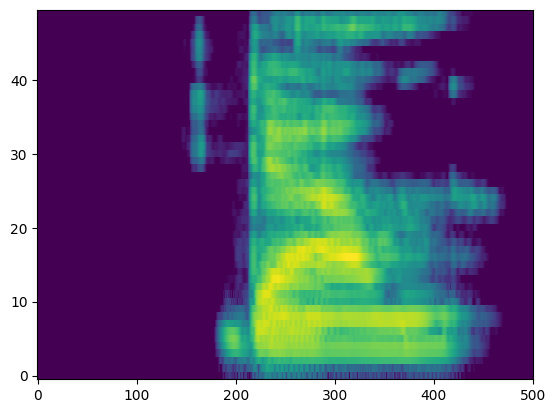

In [32]:
display_spectrogram(A[0])

In [31]:
A, alabels = next(iter(trainloader))
display_spectrogram(A[0][0])

fig, axes = plt.subplots(2, 2)
r, c = 0, 0
for i, patch in enumerate(patches[1]):
    spec_db = librosa.power_to_db(patch.numpy())
    axes[1-r][c].imshow(spec_db, origin="lower", aspect="auto", interpolation="nearest")
    
    c += 1
    if c >= 2:
        c = 0
        r += 1
        
    if r >= 2:
        break

plt.show()

KeyboardInterrupt: 

# Transformer architecture

<img src="../reports/figures/transformer_encoder2.png" alt="drawing" width="250"/>

# Patch embeddings

**batch patching test**

In [6]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [9]:
class TransformerDev(nn.Module):
    def __init__(self, tensor_dims, dropout, feedforward_dim, num_heads):

        assert len(tensor_dims) == 4

        super().__init__()
        self.td = tensor_dims
        self.batch_len = tensor_dims[0]
        self.embedding_dim = 559
        self.LinearEmbedding = nn.Linear(self.td[2] * self.td[3], self.embedding_dim)
        self.register_buffer('position_embeddings', torch.arange(start = 1, end = self.td[1] + 1)
                             .unsqueeze(0).unsqueeze(2).expand(self.batch_len, self.td[1], 1))

        # classification embedding - lenght of pixels in patch
        self.clt = nn.Parameter(torch.zeros(1, 1, self.embedding_dim + 1))
        self.clt.requires_grad = True

        print(self.embedding_dim)
        self.MHA = nn.MultiheadAttention(self.embedding_dim + 1, num_heads=num_heads, batch_first=True)
        self.MHAs = clones(self.MHA, 20)

        self.norm1 = nn.LayerNorm(self.embedding_dim + 1)
        self.norm2 = nn.LayerNorm(self.embedding_dim + 1)

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop_feedforward = nn.Dropout(dropout)

        self.lin1 = nn.Linear(self.embedding_dim + 1, feedforward_dim)
        self.lin2 = nn.Linear(feedforward_dim, self.embedding_dim + 1)

        self.head = nn.Linear(self.embedding_dim + 1, 30)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        # We start with tensor (B - batch, P - patches, W - width, H - height)
        tensor_dims = x.shape
        batch_size = x.shape[0]
        
        try:
            x = x.reshape(batch_size, self.td[1], self.td[2] * self.td[3])
        except Exception as e:
            print(f"Reshaping {x.shape} to {self.td[0]}, {self.td[1]}, {self.td[2] * self.td[3]}\n{e}")
        x = self.LinearEmbedding(x)
        
        # concat number of current patch at the end
        x = torch.cat([x, self.position_embeddings[:batch_size]], dim=2)

        # concat classification embedding
        clt_expanded = self.clt.expand(batch_size, -1, -1)
        x = torch.concat([clt_expanded, x], dim=1)

        # Pass to MultiHeadAttention
        for mha in self.MHAs:
            x, attn_weights = mha(x, x, x)
        
        # Then combine outputs as needed
        x2 = torch.stack(x2).mean(dim=0)  # or whatever combining method you need
        x = x + self.drop1(x2)
        x = self.norm1(x)

        x2 = self.lin2(
            self.drop_feedforward(
                fn_t.relu(
                    self.lin1(x)
                )
            )
        )

        x = x + self.drop2(x2)
        x = self.norm2(x)
        
        x = self.head(x[:, 0, :])
        x = self.sm(x)
        
        return x

In [10]:

from time import time

start_absolute = time()
start = time()

for i, (patches, labels) in enumerate(trainloader):
    print(f"batch {i}, time: {time()-start}, start from beginning: {time()-start_absolute}, avg: {(time()-start_absolute)/(i+1)}")
    start = time()
    

batch 0, time: 4.313716888427734, start from beginning: 4.313745737075806, avg: 4.313749074935913
batch 1, time: 0.00010418891906738281, start from beginning: 4.314018964767456, avg: 2.1570099592208862
batch 2, time: 0.2173304557800293, start from beginning: 4.531375169754028, avg: 1.510459025700887
batch 3, time: 0.0003752708435058594, start from beginning: 4.531886577606201, avg: 1.1329721808433533
batch 4, time: 6.866455078125e-05, start from beginning: 4.531994104385376, avg: 0.9063989639282226
batch 5, time: 6.890296936035156e-05, start from beginning: 4.532087802886963, avg: 0.7553480863571167
batch 6, time: 3.4693992137908936, start from beginning: 8.001516103744507, avg: 1.1430740697043282
batch 7, time: 0.01456308364868164, start from beginning: 8.016199111938477, avg: 1.0020250976085663
batch 8, time: 0.1731266975402832, start from beginning: 8.189383506774902, avg: 0.9099316596984863
batch 9, time: 0.4331092834472656, start from beginning: 8.622561931610107, avg: 0.862256360

KeyboardInterrupt: 

In [9]:
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set device properly with index if needed
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

model = TransformerDev([512, 4, 25, 45], dropout=0, feedforward_dim=1024, num_heads=8)
model = model.to(device)

classes = [
    'bird', 'dog', 'eight', 'four', 'happy', 'left', 'nine', 
    'off', 'one', 'seven', 'six', 'three', 'two', 'wow', 'zero',
    'bed', 'cat', 'down', 'five', 'go', 'house', 'marvin', 'no',
    'on', 'right', 'sheila', 'stop', 'tree', 'up', 'yes'
]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    
    for i, (patches, labels) in enumerate(trainloader):
        patches= patches.to(device)
        label_indices = torch.tensor([class_to_idx[label] for label in labels], device=device)
        
        optimizer.zero_grad()
        outputs = model(patches)
        #print(f"outputs: {outputs}\nlabel_indices: {label_indices}")
        loss = criterion(outputs, label_indices)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.detach().item()
        running_loss += current_loss
        batch_loss += current_loss
        if i % 50 == 49:
            print(f"Batch {i+1} loss: {batch_loss:.4f}")
            batch_loss = 0.0
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}')

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4070 Ti
CUDA Version: 12.8
Using device: cuda:0


NameError: name 'TransformerDev' is not defined

In [13]:
def attention(Q, K, V):
    """
    Perform attention operation
    """
    d_k = Q.size(-1)
    out = torch.matmul(Q, K.transpose()) / torch.math.sqrt(d_k) # transpose arguments?
    out = torch.matmul(out.softmax(), V)
    return out



In [14]:
class LayerNorm:
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        d_model : int
            Neurons in hidden layers
        """

        super().__init__()

        self.h = h
        self.d_k = d_model // h
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.linears = clones(nn.Linear(d_model), 4)

        

    def forward(self, Q, K, V):
        """
        Q = Embedding * W^Q
        K = Embedding * W^K
        V = Embedding * W^V
        """

        batch_len = Q.size(0)

        Q, K, V = [
            lin(x).view(batch_len, -1, self.h, self.d_k).transpose(-2, -1)
            for lin, x in zip(self.linears, (Q, K, V))
        ]
        return Q, K, V
    # Concat heads
    # Matmul W^O

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layer):
        super.__init__()
        self.norm1 = LayerNorm(layer.size)
        # MultiHead
        # residual connection
        # layer normalization
        # MLP
        # residual connection

    def forward(self, x):
        return x

In [ ]:
class LinearProjectionOfPatches(nn.Module):
    def __init__(self, dim_in, dim_out):
        super.__init__()

        self.L1 = nn.Linear(dim_in, dim_out)
        
    def forward(self, x):
        x = self.L1(x)
        return x

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        img_dim=(50, 90)
        patch_dim=(10,10)
        Lin1Dim = 128

        self.PE = PatchEmbedding(img_dim=img_dim, patch_dim=patch_dim)
        self.PELin = LinearProjectionOfPatches(img_dim[0] * img_dim[1], Lin1Dim)

        self.clt = nn.Parameter(torch.zeros(Lin1Dim))
        self.clt.requires_grad = True

        # add positional embeddings

    def forward(self, x):
        x = self.PE(x)
        x = self.PELin(x)
        x = torch.concat(x, self.clt)
        # Encoder()


        return x

# Classification token

# Positional embeddings

# Multi-Head Attention

# Residual layers

# Another verison

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

    def forward(self, x):
        # Self-attention + residual + norm
        attn_out, _ = self.mha(x, x, x)
        x = x + self.dropout1(attn_out)
        x = self.norm1(x)

        # FFN + residual + norm
        ffn_out = self.ffn(x)
        x = x + self.dropout2(ffn_out)
        x = self.norm2(x)
        return x

class TransformerDev2(nn.Module):
    def __init__(self,
                 batch_size: int,
                 num_patches: int,
                 patch_flat: int,
                 embed_dim: int = 559,
                 num_heads: int = 8,
                 ff_dim: int = 1024,
                 num_layers: int = 20,
                 num_classes: int = 30,
                 dropout: float = 0.0):
        super().__init__()
        # patch embedding
        self.embed = nn.Linear(patch_flat, embed_dim)
        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim + 1))
        # positional embeddings for CLS + patches
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim + 1)
        )

        # initial projection to embed+1 (we’ll append a position index as a feature)
        self.proj = nn.Linear(embed_dim, embed_dim + 1)

        # stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim + 1, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # classification head (raw logits)
        self.head = nn.Linear(embed_dim + 1, num_classes)

        # init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: (B, P, W, H)
        B, P, W, H = x.shape
        x = x.view(B, P, W * H)              # (B, P, patch_flat)
        x = self.embed(x)                    # (B, P, embed_dim)

        # project to embed_dim+1 (prep for concatenating pos idx feature)
        x = self.proj(x)                     # (B, P, embed_dim+1)

        # prepend CLS token
        cls = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim+1)
        x = torch.cat((cls, x), dim=1)          # (B, P+1, embed_dim+1)

        # add positional embeddings
        x = x + self.pos_embed                 # (B, P+1, embed_dim+1)

        # pass through all blocks
        for blk in self.blocks:
            x = blk(x)

        # take CLS output and project
        logits = self.head(x[:, 0])            # (B, num_classes)
        return logits


In [16]:
num_patches = int(img_dim[0] / patch_dim[0] * img_dim[1] / patch_dim[1])
patch_pixels = patch_dim[0] * patch_dim[1]

In [17]:
device = "cuda"
model = TransformerDev2(
    batch_size=512,
    num_patches=num_patches,
    patch_flat=patch_pixels,
    embed_dim=55,
    num_heads=8,
    ff_dim=1024,
    num_layers=20,
    num_classes=30,
    dropout=0.0
).to(device)

In [18]:
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set device properly with index if needed
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

classes = [
    'bird', 'dog', 'eight', 'four', 'happy', 'left', 'nine', 
    'off', 'one', 'seven', 'six', 'three', 'two', 'wow', 'zero',
    'bed', 'cat', 'down', 'five', 'go', 'house', 'marvin', 'no',
    'on', 'right', 'sheila', 'stop', 'tree', 'up', 'yes'
]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4070 Ti
CUDA Version: 12.8
Using device: cuda:0


In [19]:
from torch import amp

torch.backends.cudnn.benchmark = True
model = torch.compile(model)
scaler = torch.amp.GradScaler('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    correct = 0
    no_images = 0
    
    for i, (patches, labels) in enumerate(trainloader):
        patches= patches.to(device, non_blocking=True)
        label_indices = torch.tensor([class_to_idx[label] for label in labels], device=device)
        
        optimizer.zero_grad()
        with amp.autocast(device_type='cuda'):
            outputs = model(patches)
            loss = criterion(outputs, label_indices)
            
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        current_loss = loss.detach().item()
        running_loss += current_loss
        batch_loss += current_loss

        correct += (outputs.argmax(dim=1) == label_indices).sum().item()
        no_images += patches.shape[0]
        
        if i % 50 == 49:
            print(f"Batch {i+1} loss: {batch_loss:.4f}, accuracy: {correct/no_images}")
            batch_loss = 0.0
            correct = 0
            no_images = 0
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}')

Batch 50 loss: nan, accuracy: 0.0275
Batch 100 loss: nan, accuracy: 0.027109375
Batch 150 loss: nan, accuracy: 0.028671875
Batch 200 loss: nan, accuracy: 0.027191046658259773
Epoch [1/5], Loss: nan
Batch 50 loss: nan, accuracy: 0.0275
Batch 100 loss: nan, accuracy: 0.028671875
Batch 150 loss: nan, accuracy: 0.02671875
Batch 200 loss: nan, accuracy: 0.027585119798234553
Epoch [2/5], Loss: nan
Batch 50 loss: nan, accuracy: 0.02625


KeyboardInterrupt: 

# Attempt 3

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp # For automatic mixed precision

# --- Transformer Block Definition (Unchanged) ---
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        # batch_first=True expects input shape (Batch, Sequence, Features)
        self.mha = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True), # Using inplace ReLU can save memory
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

    def forward(self, x):
        # Pre-Normalization variation (Norm -> Attention -> Residual)
        # Self-attention + residual + norm
        x_norm = self.norm1(x)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm) # Q=K=V for self-attention
        x = x + self.dropout1(attn_out)
        # x = self.norm1(x) # Original post-norm location

        # Pre-Normalization variation (Norm -> FFN -> Residual)
        # FFN + residual + norm
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout2(ffn_out)
        # x = self.norm2(x) # Original post-norm location
        return x

# --- Simplified Transformer Model Definition ---
class TransformerSimplified(nn.Module):
    def __init__(self,
                 num_patches: int,
                 patch_flat: int,          # Number of features per flattened patch
                 embed_dim: int = 64,      # Simplified: Divisible by num_heads
                 num_heads: int = 8,
                 ff_dim: int = 1024,       # Feedforward dimension
                 num_layers: int = 20,     # Number of Transformer blocks
                 num_classes: int = 30,
                 dropout: float = 0.1):   # Added dropout
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.embed_dim = embed_dim
        self.num_patches = num_patches

        # 1. Patch embedding layer
        self.embed = nn.Linear(patch_flat, embed_dim)

        # 2. CLS token parameter
        # Shape: (1, 1, embed_dim) - batch, seq_len=1, features
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 3. Positional embeddings for CLS token + patches
        # Shape: (1, num_patches + 1, embed_dim) - batch, seq_len=P+1, features
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim)
        )
        # Removed the proj layer: nn.Linear(embed_dim, embed_dim + 1)

        # 4. Stack of transformer blocks
        # Each block operates on embed_dim
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # 5. Final LayerNorm (often helpful before the classification head)
        self.norm = nn.LayerNorm(embed_dim)

        # 6. Classification head (takes the CLS token output)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialization
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        # Initialize linear layers (optional but good practice)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
             nn.init.zeros_(m.bias)
             nn.init.ones_(m.weight)
        elif isinstance(m, nn.Parameter): # For cls_token, pos_embed if not handled separately
             if m.dim() > 1:
                 nn.init.trunc_normal_(m, std=0.02)

    def forward(self, x):
        # Input x: (B, P, W, H) - Batch, NumPatches, PatchWidth, PatchHeight
        B = x.shape[0]
        P = self.num_patches # Should match x.shape[1] if input is correct
        # Flatten patches: (B, P, W*H)
        x = x.view(B, P, -1)

        # Embed patches: (B, P, W*H) -> (B, P, embed_dim)
        x = self.embed(x)

        # Prepend CLS token
        # Expand CLS token to match batch size: (1, 1, embed_dim) -> (B, 1, embed_dim)
        cls = self.cls_token.expand(B, -1, -1)
        # Concatenate along sequence dimension: (B, 1+P, embed_dim)
        x = torch.cat((cls, x), dim=1)

        # Add positional embeddings
        # pos_embed shape: (1, P+1, embed_dim) - broadcasts across batch dimension
        x = x + self.pos_embed

        # Pass through all transformer blocks
        for blk in self.blocks:
            x = blk(x)

        # Apply final LayerNorm
        x = self.norm(x)

        # Take the output corresponding to the CLS token (index 0)
        cls_output = x[:, 0] # Shape: (B, embed_dim)

        # Pass CLS token output through the classification head
        logits = self.head(cls_output) # Shape: (B, num_classes)
        return logits

batch_size = 512 # From original code
num_classes = 30 # From original code

# Calculate number of patches and flattened patch size
if (img_dim[0] % patch_dim[0] != 0) or (img_dim[1] % patch_dim[1] != 0):
    raise ValueError("Image dimensions must be divisible by patch dimensions")

num_patches_h = img_dim[0] // patch_dim[0]
num_patches_w = img_dim[1] // patch_dim[1]
num_patches = num_patches_h * num_patches_w
patch_flat = patch_dim[0] * patch_dim[1] * 1 # Assuming 1 channel (e.g., grayscale) - Adjust if using RGB (multiply by 3)

print(f"Image Dimensions: {img_dim}")
print(f"Patch Dimensions: {patch_dim}")
print(f"Number of Patches: {num_patches}")
print(f"Patch Flattened Size: {patch_flat}")

# --- Device Setup ---
print("\n--- Device Setup ---")
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Use specific GPU if available
    print(f"CUDA Available: True")
    print(f"Using CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.benchmark = True # Enable CuDNN benchmark mode
else:
    device = torch.device("cpu")
    print(f"CUDA Available: False")
    print(f"Using device: {device}")

# --- Model Instantiation ---
print("\n--- Model Instantiation ---")
model = TransformerSimplified(
    num_patches=num_patches,
    patch_flat=patch_flat,
    embed_dim=256,      # Simplified: Multiple of num_heads (8)
    num_heads=8,       # Keep as 8
    ff_dim=1024,       # Feedforward dimension
    num_layers=20,     # Keep as 20
    num_classes=num_classes,
    dropout=0.1        # Added dropout
).to(device)

print(f"Model created with embed_dim={model.embed_dim}")
# Compile the model (optional, requires PyTorch 2.0+)
# Can sometimes improve speed but might hide errors initially.
# Comment out if issues persist after other changes.
try:
    model = torch.compile(model)
    print("Model compiled successfully.")
except Exception as e:
    print(f"Model compilation failed: {e}. Proceeding without compilation.")


# Optimizer with reduced learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3) # REDUCED LR
# Loss Function
criterion = nn.CrossEntropyLoss()
# Automatic Mixed Precision Scaler
# Use enabled=True/False to easily switch AMP on/off for debugging
scaler = torch.amp.GradScaler(enabled=False)
print(f"AMP GradScaler enabled: {scaler.is_enabled()}")

# --- Training Loop ---
print("\n--- Starting Training Loop ---")
epochs = 5
max_grad_norm = 1.0 # Gradient clipping value

for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    batch_loss_tracker = 0.0 # Track loss for printing every N batches
    correct_tracker = 0 # Track correct predictions for printing every N batches
    samples_tracker = 0 # Track number of samples for printing every N batches
    total_correct = 0
    total_samples = 0

    print_every = 50 # Print stats every 50 batches

    for i, batch in enumerate(fast_trainloader):
        # Check if batch format is correct
        if not (isinstance(batch, (list, tuple)) and len(batch) == 2):
             print(f"Error: DataLoader yielding unexpected batch format: {type(batch)}. Expected (patches, labels).")
             # Handle error appropriately, e.g., skip batch or raise exception
             continue # Skip this batch

        patches, labels = batch
        
        # Validate patch shape (optional but helpful)
        expected_shape = (patches.shape[0], num_patches, patch_dim[0], patch_dim[1])
        if patches.shape != expected_shape:
            print(f"Warning: Batch {i} has unexpected patch shape. Got {patches.shape}, expected {expected_shape}")
            # Decide how to handle this (e.g., skip, reshape if possible)
            # continue # Skip if shape is wrong

        # Convert labels to indices tensor
        try:
            label_indices = torch.tensor([class_to_idx[label] for label in labels], dtype=torch.long, device=device)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in class_to_idx mapping. Skipping batch {i}.")
            continue # Skip batch if a label is invalid

        patches = patches.to(device, non_blocking=True)
        # label_indices is already created on the correct device

        optimizer.zero_grad(set_to_none=True) # More memory efficient

        # Automatic Mixed Precision context
        with amp.autocast(device_type=device.type, enabled=scaler.is_enabled()):
            outputs = model(patches) # Forward pass
            loss = criterion(outputs, label_indices) # Calculate loss

        # Check for NaN/inf loss BEFORE backward pass
        if not torch.isfinite(loss):
             print(f"Epoch {epoch+1}, Batch {i+1}: Detected non-finite loss ({loss.detach().item()}). Skipping backward/step.")
             # Consider stopping training or debugging further here
             # You might want to inspect `outputs` and `label_indices`
             # E.g., print(outputs.min(), outputs.max(), outputs.mean())
             continue # Skip optimization steps for this batch

        # Backward pass and optimization using scaler
        scaler.scale(loss).backward() # Scales loss and calls backward

        # Gradient Clipping (unscale gradients before clipping)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        scaler.step(optimizer) # Optimizer step (unscales gradients internally)
        scaler.update() # Update scaler for next iteration

        # --- Statistics Tracking ---
        current_loss = loss.detach().item()
        running_loss += current_loss
        batch_loss_tracker += current_loss

        # Calculate accuracy for the current batch
        predictions = outputs.argmax(dim=1)
        batch_correct = (predictions == label_indices).sum().item()
        batch_samples = patches.shape[0] # Number of items in the batch

        correct_tracker += batch_correct
        samples_tracker += batch_samples
        total_correct += batch_correct
        total_samples += batch_samples

        # Print batch statistics periodically
        if (i + 1) % print_every == 0 or (i + 1) == len(trainloader):
            batch_accuracy = correct_tracker / samples_tracker if samples_tracker > 0 else 0.0
            avg_batch_loss = batch_loss_tracker / print_every if (i + 1) % print_every == 0 else batch_loss_tracker / ((i + 1) % print_every)

            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], "
                  f"Avg Batch Loss: {avg_batch_loss:.4f}, Batch Accuracy: {batch_accuracy:.4f}")
            # Reset trackers for the next set of batches
            batch_loss_tracker = 0.0
            correct_tracker = 0
            samples_tracker = 0

    # Print epoch statistics
    epoch_loss = running_loss / len(trainloader) if len(trainloader) > 0 else 0.0
    epoch_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    print(f"--- Epoch [{epoch+1}/{epochs}] Summary ---")
    print(f"Average Loss: {epoch_loss:.4f}, Overall Accuracy: {epoch_accuracy:.4f}")
    print("-" * 30)

print("Training Finished.")

Image Dimensions: (64, 105)
Patch Dimensions: (16, 15)
Number of Patches: 28
Patch Flattened Size: 240

--- Device Setup ---
CUDA Available: True
Using CUDA Device: NVIDIA GeForce RTX 4070 Ti
CUDA Version: 12.8

--- Model Instantiation ---
Model created with embed_dim=64
Model compiled successfully.

--- Training Setup ---
AMP GradScaler enabled: False

--- Starting Training Loop ---
Epoch [1/5], Batch [50/200], Avg Batch Loss: 3.4208, Batch Accuracy: 0.0373
Epoch [1/5], Batch [100/200], Avg Batch Loss: 3.3891, Batch Accuracy: 0.0393
Epoch [1/5], Batch [150/200], Avg Batch Loss: 3.2755, Batch Accuracy: 0.0780
Epoch [1/5], Batch [200/200], Avg Batch Loss: 3.1990, Batch Accuracy: 0.0941
--- Epoch [1/5] Summary ---
Average Loss: 3.3211, Overall Accuracy: 0.0621
------------------------------
Epoch [2/5], Batch [50/200], Avg Batch Loss: 3.0557, Batch Accuracy: 0.1311
Epoch [2/5], Batch [100/200], Avg Batch Loss: 2.9168, Batch Accuracy: 0.1692
Epoch [2/5], Batch [150/200], Avg Batch Loss: 2

KeyboardInterrupt: 

Process Process-148:
Process Process-145:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mpuscian/Envs/DeepLearning/lib64/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 372, in _worker_loop
    if done_event.is_set():
       ~~~~~~~~~~~~~~~~~^^
  File "/home/mpuscian/Envs/DeepLearning/lib64/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 372, in _worker_loop
   

In [10]:
# --- Data and Training Setup ---
print("\n--- Training Setup ---")
classes = [
    'bird', 'dog', 'eight', 'four', 'happy', 'left', 'nine',
    'off', 'one', 'seven', 'six', 'three', 'two', 'wow', 'zero',
    'bed', 'cat', 'down', 'five', 'go', 'house', 'marvin', 'no',
    'on', 'right', 'sheila', 'stop', 'tree', 'up', 'yes'
]
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()} # Useful for validation/inference


--- Training Setup ---


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp # For automatic mixed precision
# --- NEW IMPORTS ---
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
# --- /NEW IMPORTS ---

# --- Transformer Block Definition (Unchanged) ---
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout1(attn_out)
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout2(ffn_out)
        return x

# --- Simplified Transformer Model Definition (Unchanged) ---
class TransformerSimplified(nn.Module):
    def __init__(self,
                 num_patches: int,
                 patch_flat: int,
                 embed_dim: int = 64,
                 num_heads: int = 8,
                 ff_dim: int = 1024,
                 num_layers: int = 20,
                 num_classes: int = 30,
                 dropout: float = 0.1):
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.embed = nn.Linear(patch_flat, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        # Removed Parameter check as it's handled by direct init above

    def forward(self, x):
        B = x.shape[0]
        P = self.num_patches
        x = x.view(B, P, -1)
        x = self.embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        return logits

# --- Configuration ---
# Assuming img_dim and patch_dim are defined elsewhere
# img_dim = (64, 105)
# patch_dim = (16, 15)

# Calculate number of patches and flattened patch size
if (img_dim[0] % patch_dim[0] != 0) or (img_dim[1] % patch_dim[1] != 0):
    raise ValueError("Image dimensions must be divisible by patch dimensions")
num_patches_h = img_dim[0] // patch_dim[0]
num_patches_w = img_dim[1] // patch_dim[1]
num_patches = num_patches_h * num_patches_w
patch_flat = patch_dim[0] * patch_dim[1] * 1 # Assuming 1 channel

print(f"Image Dimensions: {img_dim}")
print(f"Patch Dimensions: {patch_dim}")
print(f"Number of Patches: {num_patches}")
print(f"Patch Flattened Size: {patch_flat}")

# --- Device Setup (Unchanged) ---
print("\n--- Device Setup ---")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"CUDA Available: True")
    print(f"Using CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print(f"CUDA Available: False")
    print(f"Using device: {device}")

# --- Model Instantiation (Unchanged)---
print("\n--- Model Instantiation ---")
model = TransformerSimplified(
    num_patches=num_patches,
    patch_flat=patch_flat,
    embed_dim=128,
    num_heads=8,
    ff_dim=512,
    num_layers=8,
    num_classes=30, # num_classes already defined
    dropout=0.3
).to(device)
print(f"Model created with embed_dim={model.embed_dim}")


# --- Data Setup (Assuming defined elsewhere) ---
# Make sure trainloader (or fast_trainloader) and classes are defined
# Example:
# trainloader = ...
# classes = [...]
# class_to_idx = {cls: i for i, cls in enumerate(classes)}
# idx_to_class = {i: cls for cls, i in class_to_idx.items()}
# num_classes = len(classes) # Ensure this matches model's num_classes


# --- Training Setup ---
print("\n--- Training Setup ---")

# --- NEW: Training Hyperparameters ---
epochs = 50          # INCREASED: Train for significantly longer
base_lr = 1e-3       # ADJUSTED: Starting point, can be tuned (e.g., 1e-4, 5e-4)
warmup_epochs = 3    # Number of epochs for linear warmup
min_lr = 1e-5        # Minimum learning rate for cosine annealing
weight_decay = 0.075  # Weight decay for AdamW (typical value for ViTs)
max_grad_norm = 1.0  # Gradient clipping value (Unchanged)
batch_size = 256     # Keep consistent with DataLoader (Unchanged)
# --- /NEW: Training Hyperparameters ---

# Optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

# Loss Function
criterion = nn.CrossEntropyLoss()

# --- NEW: Learning Rate Scheduler Setup ---
# 1. Linear Warmup Scheduler
# Starts from a factor relative to base_lr, ends at base_lr
warmup_start_factor = min_lr / base_lr # Start near minimum LR
warmup_scheduler = LinearLR(optimizer,
                           start_factor=warmup_start_factor,
                           end_factor=1.0,
                           total_iters=warmup_epochs)

# 2. Cosine Annealing Scheduler (main phase)
# Starts after warmup, decays to min_lr
cosine_epochs = epochs - warmup_epochs
main_scheduler = CosineAnnealingLR(optimizer,
                                 T_max=cosine_epochs,
                                 eta_min=min_lr)

# 3. Combine Schedulers
# Use warmup_scheduler for warmup_epochs, then switch to main_scheduler
scheduler = SequentialLR(optimizer,
                       schedulers=[warmup_scheduler, main_scheduler],
                       milestones=[warmup_epochs])
print(f"LR Scheduler: Warmup ({warmup_epochs} epochs) + Cosine Annealing ({cosine_epochs} epochs)")
# --- /NEW: Learning Rate Scheduler Setup ---


# Automatic Mixed Precision Scaler
# --- MODIFIED: Enable AMP ---
scaler = torch.amp.GradScaler(enabled=False)
print(f"AMP GradScaler enabled: {scaler.is_enabled()}")
# --- /MODIFIED: Enable AMP ---

# --- Training Loop ---
print("\n--- Starting Training Loop ---")
print_every = 50 # Print stats every 50 batches

# Assume `fast_trainloader` is your DataLoader instance
# Ensure it's defined correctly before this loop
if 'fast_trainloader' not in locals():
     raise NameError("DataLoader 'fast_trainloader' is not defined.")
if 'class_to_idx' not in locals():
     raise NameError("'class_to_idx' mapping is not defined.")


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    batch_loss_tracker = 0.0
    correct_tracker = 0
    samples_tracker = 0
    total_correct = 0
    total_samples = 0

    # It's good practice to wrap the dataloader with enumerate
    num_batches = len(fast_trainloader)

    for i, batch in enumerate(fast_trainloader):
        if not (isinstance(batch, (list, tuple)) and len(batch) == 2):
            print(f"Error: DataLoader yielding unexpected batch format: {type(batch)}. Expected (patches, labels).")
            continue

        patches, labels = batch

        # Ensure patches are float (common requirement, esp. for AMP)
        # and labels are appropriate type (e.g., strings if they are keys for class_to_idx)
        if not isinstance(patches, torch.Tensor) or patches.dtype != torch.float32:
             # Add conversion if necessary, e.g., patches = patches.float()
             # Or ensure your DataLoader yields float tensors
             pass # Assuming patches are already correct float tensors

        # Validate patch shape (optional but helpful)
        # Assuming patches input to model should be (B, P, Patch_H, Patch_W) initially
        # B = patches.shape[0] # Batch size from current batch
        # expected_shape = (B, num_patches, patch_dim[0], patch_dim[1]) # Requires patch_dim to be defined
        # if patches.shape[1:] != expected_shape[1:]: # Check dimensions after batch
        #      print(f"Warning: Batch {i} has unexpected patch shape. Got {patches.shape}, expected {expected_shape}")
             # continue # Skip if shape is wrong - uncomment if strict checking needed

        try:
            label_indices = torch.tensor([class_to_idx[label] for label in labels], dtype=torch.long, device=device)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in class_to_idx mapping. Skipping batch {i}.")
            continue
        except TypeError:
             # Handle cases where labels might already be indices (tensors)
             if isinstance(labels, torch.Tensor):
                 label_indices = labels.to(device=device, dtype=torch.long)
             else:
                 print(f"Error: Unexpected label type: {type(labels)}. Skipping batch {i}.")
                 continue


        patches = patches.to(device, non_blocking=True)
        # label_indices is already created on/moved to the correct device

        optimizer.zero_grad(set_to_none=True)

        with amp.autocast(device_type=device.type, enabled=scaler.is_enabled()):
            outputs = model(patches)
            loss = criterion(outputs, label_indices)

        if not torch.isfinite(loss):
            print(f"Epoch {epoch+1}, Batch {i+1}/{num_batches}: Detected non-finite loss ({loss.detach().item()}). Skipping backward/step.")
            # Consider adding code here to log problematic inputs/outputs for debugging
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer) # Unscale gradients before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        scaler.step(optimizer)
        scaler.update()

        # --- Statistics Tracking (Unchanged) ---
        current_loss = loss.detach().item()
        running_loss += current_loss
        batch_loss_tracker += current_loss
        predictions = outputs.argmax(dim=1)
        batch_correct = (predictions == label_indices).sum().item()
        batch_samples = patches.shape[0]
        correct_tracker += batch_correct
        samples_tracker += batch_samples
        total_correct += batch_correct
        total_samples += batch_samples

        if (i + 1) % print_every == 0 or (i + 1) == num_batches:
             # Calculate average over the tracked period
             avg_batch_loss = batch_loss_tracker / samples_tracker if samples_tracker > 0 else 0.0
             batch_accuracy = correct_tracker / samples_tracker if samples_tracker > 0 else 0.0
             # Get current Learning Rate from the optimizer
             current_lr = optimizer.param_groups[0]['lr']

             print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{num_batches}], "
                   f"Avg Batch Loss: {avg_batch_loss:.4f}, Batch Accuracy: {batch_accuracy:.4f}, "
                   f"LR: {current_lr:.1e}") # Display current LR

             # Reset trackers for the next print interval
             batch_loss_tracker = 0.0
             correct_tracker = 0
             samples_tracker = 0

    # --- Epoch Summary ---
    epoch_loss = running_loss / num_batches if num_batches > 0 else 0.0
    epoch_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    # Get LR at the end of the epoch (after scheduler step)
    final_epoch_lr = optimizer.param_groups[0]['lr']
    print(f"--- Epoch [{epoch+1}/{epochs}] Summary ---")
    print(f"Average Loss: {epoch_loss:.4f}, Overall Accuracy: {epoch_accuracy:.4f}, Final LR: {final_epoch_lr:.1e}")
    model.eval()
    correct_val = 0
    no_labels_val = 0
    for patches_val, labels_val in valloader:
        patches_val= patches_val.to(device)
        label_indices = torch.tensor([class_to_idx[label] for label in labels_val], device=device)
        
        outputs = model(patches_val)
        
        correct_val += (outputs.argmax(dim=1) == label_indices).sum().item()
        no_labels_val += patches_val.shape[0]
    print(f"Validation acc: {correct_val/no_labels_val:.4f}")
    print("-" * 30)

    # --- IMPORTANT: Step the Scheduler after each epoch ---
    scheduler.step()
    # --- /IMPORTANT ---


print("Training Finished.")

# Remember to also implement validation loops to monitor generalization performance.

Image Dimensions: (64, 105)
Patch Dimensions: (16, 15)
Number of Patches: 28
Patch Flattened Size: 240

--- Device Setup ---
CUDA Available: True
Using CUDA Device: NVIDIA GeForce RTX 4070 Ti
CUDA Version: 12.8

--- Model Instantiation ---
Model created with embed_dim=128

--- Training Setup ---
LR Scheduler: Warmup (3 epochs) + Cosine Annealing (47 epochs)
AMP GradScaler enabled: False

--- Starting Training Loop ---
Epoch [1/50], Batch [50/200], Avg Batch Loss: 0.0133, Batch Accuracy: 0.0344, LR: 1.0e-05
Epoch [1/50], Batch [100/200], Avg Batch Loss: 0.0133, Batch Accuracy: 0.0368, LR: 1.0e-05
Epoch [1/50], Batch [150/200], Avg Batch Loss: 0.0133, Batch Accuracy: 0.0436, LR: 1.0e-05
Epoch [1/50], Batch [200/200], Avg Batch Loss: 0.0133, Batch Accuracy: 0.0478, LR: 1.0e-05
--- Epoch [1/50] Summary ---
Average Loss: 3.4000, Overall Accuracy: 0.0406, Final LR: 1.0e-05
Validation acc: 0.0655
------------------------------
Epoch [2/50], Batch [50/200], Avg Batch Loss: 0.0128, Batch Accura

KeyboardInterrupt: 

# Evaluation

In [14]:
model.load_state_dict(torch.load("transformer_1.pth"))

<All keys matched successfully>

In [15]:
device

'cuda'

In [45]:
model.eval()
for i, (batch, labels) in enumerate(valloader):
    batch = batch.to(device)
    outputs = model(batch)
    label_indices = torch.tensor([class_to_idx[label] for label in labels], dtype=torch.long, device=device)
    

In [48]:
lll2 = torch.tensor([class_to_idx[label] for label in lll])

In [59]:
lll2

tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 

In [57]:
kkk.argmax(dim = 1)

tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 29, 29, 

In [21]:
import pathlib

In [34]:
np.unique(np.array([pathlib.Path(path).parents[1] for path in valset.paths]))

array([PosixPath('/home/mpuscian/Desktop/repozytoria/MINI_projects/Transformers/data/processed/splited_data/validation')],
      dtype=object)

In [35]:
np.unique(np.array([pathlib.Path(path).parents[1] for path in trainset.paths]))

array([PosixPath('/home/mpuscian/Desktop/repozytoria/MINI_projects/Transformers/data/processed/splited_data/train')],
      dtype=object)